In [1]:
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, sys, os
import pandas as pd, seaborn as sns, argparse, pyemma as py, pickle, copy
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from hde import HDE, analysis

sys.path.insert(1, '../msms/')
from utils import * 

Using TensorFlow backend.


In [4]:
seq = 'TTTTTTTTTTT' #'CCTATATATCC' #'TATAGCGATAT' #'CGCATATATAT'#  #'
base_list = [base for base in abasic_configs[seq].keys()]
tstep = 100 #ps

# leave out first skip frames
max_frames = 100000
max_trajs = 25
max_epochs = 10  # for traininng SRVs

lag = 10 # converged for srv, tica not quite
dim = 5 #  3 captures most pertinent modes 

In [3]:


SRV_list = []
TICA_list = []
srv_indv_list = []
tica_indv_list = []
comb_dists = []
all_dists = []

# fit each individually
for base in base_list:

    # combine first and second run
    npy_name = glob.glob(f'../abasic_dists/{seq}_msm_add-Tms/{base}*')[0]
    dists = np.load(npy_name)[:max_trajs, -max_frames:, :]
    all_dists.append(dists)

    # get common basis and combine for later
    common_idxs = translate_pairs(len(seq), base)
    #comb_dists += [d[:, common_idxs] for d in dists]

    SRV = fit_SRV([1/d for d in dists], dim, max_epochs, lag)
    srv_basis = [SRV.transform(1/d) for d in dists]
    srv_indv_list.append(srv_basis)
    SRV_list.append(SRV)

    TICA = py.coordinates.tica([1/d for d in dists], dim=dim, lag=lag)
    tica_basis = TICA.get_output()
    tica_indv_list.append(tica_basis)
    TICA_list.append(TICA)
    #print(base, dists.shape)
    

W0922 12:16:22.395210 140298705835840 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0922 12:16:22.412833 140298705835840 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0922 12:16:22.415668 140298705835840 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0922 12:16:22.563732 140298705835840 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/

control (25, 100000, 121)


b2 (25, 100000, 110)


b4 (25, 100000, 110)


b6 (25, 100000, 110)


In [ ]:
cluster_stride = 100
n_clustercenters = 200
nits, its_lags = 5, 100
msm_lag = lag

committer_quota = 0.25
committor_list = []

dtraj_list = []
cluster_list = []
its_list = []
msm_list = []
H_list, D_list = [], []

fig, axes = plt.subplots(4, figsize=(10, 5), sharey=True)
for base, base_dists, basis, ax in zip(base_list, all_dists, srv_indv_list, axes):
     
    print(base, np.shape(base_dists))
    cluster = py.coordinates.cluster_kmeans(basis, 
                stride=cluster_stride, k=n_clustercenters, max_iter=50)
    cluster_list.append(cluster)

    # construct two-state pcca and determine microstate probabilities
    dtraj = cluster.dtrajs
    msm = py.msm.bayesian_markov_model(dtraj, lag=msm_lag)
    pcca = msm.pcca(2)
    pi = msm.stationary_distribution
    sorted_micros = np.argsort(msm.metastable_memberships[:, 0])

    # add microstates to each bin until quota is full
    A, pi_sum_A = [], 0
    for i in sorted_micros:
        A.append(i)
        pi_sum_A += pi[i]
        if pi_sum_A > committer_quota:
            break#'CGCATATATAT'

    # repeat in reverse direction for second bin
    B, pi_sum_B = [], 0
    for i in reversed(sorted_micros):
        B.append(i)
        pi_sum_B += pi[i]
        if pi_sum_B > committer_quota:
            break

    print(A, pi_sum_A)
    print(B, pi_sum_B)

    # determine which bin is H and D
    base_dists = np.concatenate(base_dists)
    dtraj = np.concatenate(dtraj)
    A_dtraj = np.isin(dtraj, A)
    A_mean = np.mean(base_dists[A_dtraj])
    if A_mean < 2: H, D = A, B
    else: D, H = A, B

    # evaluate committers for all intermediate micros and plots
    qf = msm.committor_forward(H, D)
    qb = msm.committor_backward(H, D)
    committor_list.append(qb)
    ax.scatter(qf, pi)
    ax.set_title(base)
    
    its = py.msm.its(dtraj, lags=its_lags, nits=nits)
    dtraj_list.append(dtraj)
    its_list.append(its)
    msm_list.append(msm)
    H_list.append(H)
    D_list.append(D)
    
plt.subplots_adjust(hspace=(0.35))

control (25, 100000, 121)


[73, 159, 41, 11, 97] 0.30609834632828703
[195, 52, 0, 78, 175, 148, 104, 141, 2, 170, 23, 147, 42, 69, 167, 67, 65, 155, 48, 129, 135, 189, 33, 21, 115, 75, 28, 44, 125, 151] 0.2520954812484638


b2 (25, 100000, 110)


[70, 11, 33, 199] 0.3382540351779131
[197, 3, 153, 166, 34, 193, 57, 85, 185, 55, 105, 2, 149, 162, 83, 95, 71, 39, 142, 104, 100, 19, 135, 84, 60, 31, 21, 144, 81] 0.25107667711271914


b4 (25, 100000, 110)


[74, 151, 2, 8, 157, 51, 176, 62, 82, 156, 136, 116, 172, 98, 122, 72, 84, 168, 75, 93, 141] 0.26831244006449145
[1, 35, 183, 66, 155] 0.2779049094715097


b6 (25, 100000, 110)


In [ ]:
# add in low temp data and cluster in same set of microstates defined above
skip_low = 2001
dtraj_low_list = []

# plot to look for differences in the bases
fig, axes = plt.subplots(4, 2, figsize=(5, 10), sharex=True, sharey=True)
pstride = 100

for base, cluster, basis, SRV, TICA, equ_dists, ax_row in \
    zip(base_list, cluster_list, srv_indv_list, SRV_list, TICA_list, all_dists, axes):
    
    # load low temp data
    npy_name = glob.glob(f'../abasic_dists/{seq}_msm_Tm-15/{base}*')[0]
    dists = np.load(npy_name)[:, skip_low:, :]
    #dists = equ_dists[:, ::pstride, :] # sanity check using same data

    # translate into SRV and TICA basis
    srv_low_basis = [SRV.transform(1/d) for d in dists]
    tica_low_basis = [TICA.transform(1/d) for d in dists]
    
    # cluster into pre-defined microstates based on srv basis
    dtraj_low = cluster.assign(srv_low_basis)
    dtraj_low_list.append(dtraj_low)
    
    # plot Tm SRV distribution compared to low T
    srv_plot_tm = np.concatenate(basis)[::pstride]
    srv_plot_low = np.concatenate(srv_low_basis)[::pstride//10]
    
    ax_row[0].scatter(srv_plot_tm[:, 0], srv_plot_tm[:, 1])
    ax_row[1].scatter(srv_plot_low[:, 0], srv_plot_low[:, 1])

    
axes[0, 0].set_title('SRV Tm')
axes[0, 1].set_title('SRV T Low')
    
## also do some structural comparisons at low temp that we can report

In [6]:
# pickle dump and load outputs for later
save_name = f'./save_outputs/{seq}_lag-{msm_lag}_dict'
save_dict = {'base_list':base_list, 
             'all_dists':all_dists, 
             'srv_indv_list':srv_indv_list, 
             'tica_indv_list':tica_indv_list,
             'SRV_list':SRV_list,
             'committor_list':committor_list,
             'dtraj_list':dtraj_list,
             'dtraj_low_list':dtraj_low_list,
             'msm_list':msm_list,
             'its_list':its_list,
             'H_list':H_list,
             'D_list':D_list,
             'cluster_list':cluster_list
            }
pickle.dump(save_dict, open(save_name, 'wb'))

In [4]:
# start here if already saved

# load from saved:
seq = 'CGCATATATAT' #'TTTTTTTTTTT' # #'TATAGCGATAT'  # #'CCTATATATCC'
lag = 1
save_name = f'./save_outputs/{seq}_lag-{lag}_dict'
save_dict = pickle.load(open(save_name, 'rb'))

base_list = save_dict['base_list'] 
all_dists = save_dict['all_dists']
srv_indv_list = save_dict['srv_indv_list']
tica_indv_list = save_dict['tica_indv_list']
committor_list = save_dict['committor_list']
dtraj_list = save_dict['dtraj_list']
msm_list = save_dict['msm_list']
its_list = save_dict['its_list']
H_list = save_dict['H_list']
D_list = save_dict['D_list']

try: dtraj_low_list = save_dict['dtraj_low_list']
except: print('no lowT data')

W0914 14:48:41.323518 139788979631936 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0914 14:48:41.339512 139788979631936 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0914 14:48:41.477215 139788979631936 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:131: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0914 14:48:41.477930 139788979631936 deprecation_wrapper.py:119] From /home/mikejones/scratch-midway2/conda_envs/srv_env/lib/python3.7/site-packages/keras/backend

[-1.000000e-05  1.000000e-05  1.250075e-01  2.500050e-01  3.750025e-01
  5.000000e-01  6.249975e-01  7.499950e-01  8.749925e-01  9.999900e-01
  1.000010e+00  1.000020e+00]
control (2500000, 121) (2500000,)
b2 (2500000, 110) (2500000,)
b4 (2500000, 110) (2500000,)
b6 (2500000, 110) (2500000,)


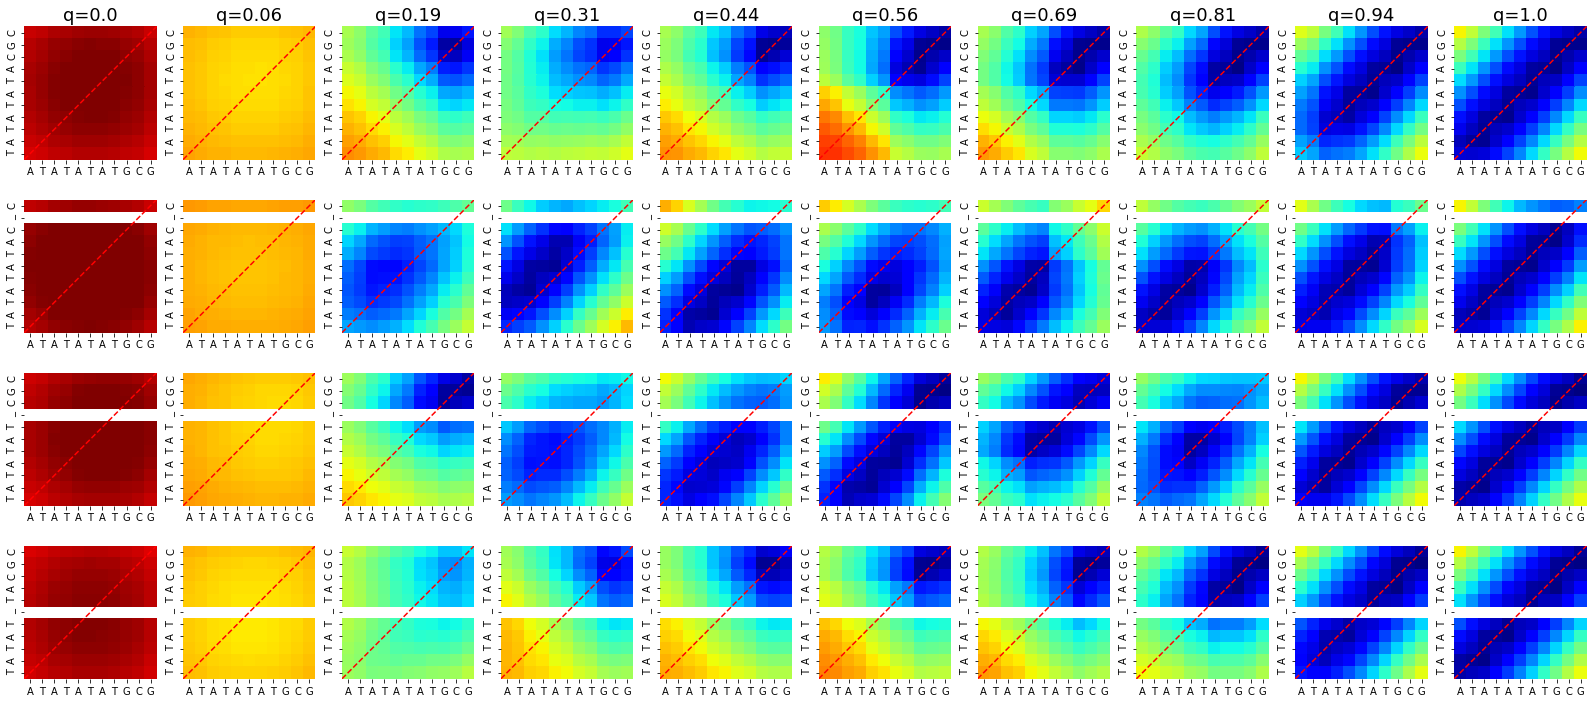

In [5]:
# make a two-dimensional projection along the committor
# check variance on these plots as well

nbins = 10 # number snapshots per traj to plot
pad = 0.00001
bin_size = (1-2*pad)/(nbins-2)
commitor_bins = np.array([-pad]+list(np.arange(pad, 1-pad, bin_size))+[1+pad, 1+2*pad])
print(commitor_bins)
n_bp = len(seq)

cbar=False
plot_val = 'mean'
complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
fig, axes = plt.subplots(4, nbins,  figsize=(28, 12))  

for i, (base, qf, dtraj, base_dists, ax_row) in \
    enumerate(zip(base_list, committor_list, dtraj_list, all_dists, axes)):
    
    # concatenate tics and dists
    base_dists = np.concatenate(base_dists)
    print(base, base_dists.shape, dtraj.shape)
    
    # format labelling
    y_ticks = [t for t in seq]
    x_ticks = [complement_dict[t] for t in reversed(seq)]
    if base != 'control': 
        tic_mask = []
        base_idx = int(base.replace('b', ''))-1
        y_ticks[base_idx] = '_'

    # find frames in bin range
    for bin_min, bin_max, ax in zip(commitor_bins, commitor_bins[1:], ax_row):
    
        # find all dists within each bin
        dist_idxs = []
        micro_idxs = np.where(np.logical_and(qf>bin_min, qf<bin_max))[0]
        for idx in micro_idxs: dist_idxs += list(np.where(dtraj==idx)[0])
            
        try:
            binned_dists = base_dists[np.array(dist_idxs)]

            # calculate wc mean of population within each bin 
            if plot_val == 'mean':
                plot_stat = np.mean(binned_dists, axis=0)
                v_min, v_max = 0.5, 5
            elif plot_val == 'std':
                plot_val = np.std(binned_dists, axis=0)
                v_min, v_max = 0, 2

            # reshape indices to fit 
            if base == 'control':
                plot_idxs = plot_stat.reshape(n_bp, n_bp)
                sns.heatmap(plot_idxs, ax=ax, vmin=v_min, vmax=v_max,
                            yticklabels=y_ticks, xticklabels=x_ticks,
                            cbar=cbar, cmap='jet')
            else:
                base_idx = int(base[-1]) - 1
                plot_idxs = plot_stat.reshape(n_bp-1, n_bp)
                plot_idxs = np.insert(plot_idxs, base_idx, 0, axis=0)
                mask = np.zeros((n_bp-1, n_bp))
                mask = np.insert(mask, base_idx, 1, axis=0)
                sns.heatmap(plot_idxs, mask=mask, ax=ax, vmin=v_min, vmax=v_max,
                            yticklabels=y_ticks, xticklabels=x_ticks,
                            cbar=cbar, cmap='jet')

            # show in-register hybridization for reference
            ax.plot(np.arange(n_bp+1), n_bp-np.arange(n_bp+1), linestyle='dashed', c='red')
        except: pass
            
        # label final row
        if base == 'control':
            ax.set_title(f'q={np.round((abs(bin_min+bin_max)/2),2)}', fontsize=18)
        
#axes[-1, 0].set_xlabel('H', fontsize=16)
#axes[-1, -1].set_xlabel('D', fontsize=16)
plt.subplots_adjust(hspace=0.3)

In [ ]:
from scipy.stats import pearsonr as pears
plot_stride=100

# check tica correlation with commitor:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
for base, dtraj, tica_indv, srv_indv, qf in zip(base_list, dtraj_list, tica_indv_list, srv_indv_list, committor_list):

    tica_traj = np.concatenate(tica_indv)[:, 0]
    srv_traj = np.concatenate(srv_indv)[:, 0]
    committer_traj = np.array(qf)[dtraj]
    
    tica_pears = np.round(pears(tica_traj, committer_traj))[0]
    srv_pears = np.round(pears(srv_traj, committer_traj))[0]
    print(base, 'TICA', np.round(tica_pears, 4))
    print(base, 'SRV', np.round(srv_pears, 4))
    
    axes[0].scatter(tica_pears/abs(tica_pears)*tica_traj[::plot_stride], committer_traj[::plot_stride], label=base)
    axes[1].scatter(srv_pears/abs(srv_pears)*srv_traj[::plot_stride], committer_traj[::plot_stride], label=base)
    
axes[0].legend()
axes[0].set_xlabel('TICA')
axes[1].set_xlabel('SRV')
axes[0].set_ylabel('Committer')

In [34]:
def score_all_cont(msm, base, dtraj, base_dists, AT_cutoff=0.7, GC_cutoff=0.65):
    '''assign A:T and G:C scores by summing all available contacts below respective cutoffs'''
    
    # find possible AT and GC pairs
    AT_possible, GC_possible = [], []
    base_dists = np.concatenate(base_dists)

    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]

    idx = 0
    for b1 in s1_bps:
        for b2 in s2_bps:
            if b1+b2 in ['AT', 'TA']:
                AT_possible.append(idx)
            elif b1+b2 in ['GC', 'CG']:
                GC_possible.append(idx)
            idx+=1
            
    print('AT len: ', len(AT_possible), 'GC len: ', len(GC_possible))

    # assign AT and GC scores
    AT_scores, GC_scores = [], []

    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        all_avgs = np.mean(base_dists[micro_idxs], axis=0)
        AT_avgs, GC_avgs = all_avgs[AT_possible], all_avgs[GC_possible]
        AT_score, GC_score = np.sum(AT_avgs<AT_cutoff), np.sum(GC_avgs<GC_cutoff)
        AT_scores.append(AT_score)
        GC_scores.append(GC_score)
        
    return AT_scores, GC_scores

def score_native_cont(msm, base, dtraj, base_dists, AT_cutoff=0.7, GC_cutoff=0.65):
    '''assign continous score based on distance between all native wc contacts'''
        
    AT_wc, GC_wc = [], []
    base_dists = np.concatenate(base_dists)
    
    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]

    s1_idx = list(np.arange(len(seq)))
    s2_idx = [i for i in reversed(s1_idx)]
    if base != 'control':
        del s1_idx[int(base.replace('b', ''))-1]
        
    idx = 0
    for b1, i1 in zip(s1_bps, s1_idx):
        for b2, i2 in zip(s2_bps, s2_idx):
            if i1==i2:
                if b1+b2 in ['AT', 'TA']:
                    AT_wc.append(idx)
                elif b1+b2 in ['GC', 'CG']:
                    GC_wc.append(idx)
            idx+=1
    
    print(AT_wc, GC_wc)
    print('AT len: ', len(AT_wc), 'GC len: ', len(GC_wc))
    
    # assign AT and GC scores
    AT_scores, GC_scores = [], []

    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        all_avgs = np.mean(base_dists[micro_idxs], axis=0)
        AT_avgs, GC_avgs = all_avgs[AT_wc], all_avgs[GC_wc]
        AT_score, GC_score = np.sum(AT_avgs<AT_cutoff), np.sum(GC_avgs<GC_cutoff)
        AT_scores.append(AT_score)
        GC_scores.append(GC_score)
        
    return AT_scores, GC_scores

def score_native_dist(msm, base, dtraj, base_dists, max_dist=1.0):
    '''assign continous score based on distance between all native wc contacts'''
    
    def score_dist(d):
        score = 2*(1-d)
        score[score < 0] = 0
        return score
        
    AT_wc, GC_wc = [], []
    base_dists = np.concatenate(base_dists)
    
    s1_bps = [t for t in seq]
    s2_bps = [complement_dict[t] for t in reversed(seq)]
    if base != 'control':
        del s1_bps[int(base.replace('b', ''))-1]

    s1_idx = list(np.arange(len(seq)))
    s2_idx = [i for i in reversed(s1_idx)]
    if base != 'control':
        del s1_idx[int(base.replace('b', ''))-1]
        
    idx = 0
    for b1, i1 in zip(s1_bps, s1_idx):
        for b2, i2 in zip(s2_bps, s2_idx):
            if i1==i2:
                if b1+b2 in ['AT', 'TA']:
                    AT_wc.append(idx)
                elif b1+b2 in ['GC', 'CG']:
                    GC_wc.append(idx)
            idx+=1
    
    print(AT_wc, GC_wc)
    print('AT len: ', len(AT_wc), 'GC len: ', len(GC_wc))
    
    # assign AT and GC scores
    AT_scores, GC_scores = [], []

    for i in range(msm.nstates):
        micro_idxs = np.where(dtraj==i)
        all_avgs = np.mean(base_dists[micro_idxs], axis=0)
        AT_avgs, GC_avgs = all_avgs[AT_wc], all_avgs[GC_wc]
        AT_score, GC_score = np.sum(score_dist(AT_avgs)), np.sum(score_dist(GC_avgs))
        AT_scores.append(AT_score)
        GC_scores.append(GC_score)
        
    return AT_scores, GC_scores


In [35]:
# MSM simluations: assign each microstate an A:T and G:C score
# score_native_cont with larger cutoff (1.0) seems to work well for CGC-end at least

AT_scores_list, GC_scores_list = [], []

for msm, base, dtraj, base_dists in zip(msm_list, base_list, dtraj_list, all_dists):

    AT_scores, GC_scores = score_native_cont(msm, base, dtraj, base_dists, AT_cutoff=1.0, GC_cutoff=1.0)
    AT_scores_list.append(np.array(AT_scores))
    GC_scores_list.append(np.array(GC_scores))

[40, 50, 60, 70, 80, 90, 100, 110] [10, 20, 30]
AT len:  8 GC len:  3
[29, 39, 49, 59, 69, 79, 89, 99] [10, 19]
AT len:  8 GC len:  2
[39, 49, 59, 69, 79, 89, 99] [10, 20, 30]
AT len:  7 GC len:  3
[40, 50, 59, 69, 79, 89, 99] [10, 20, 30]
AT len:  7 GC len:  3


[0, 125] 0 [0.677528 0.193604]
[0] 0 [0.986176]
[58] 58 [0.97028]
[10, 138, 130, 185, 65] 138 [0.229776 0.273756 0.169404 0.080504 0.109204]


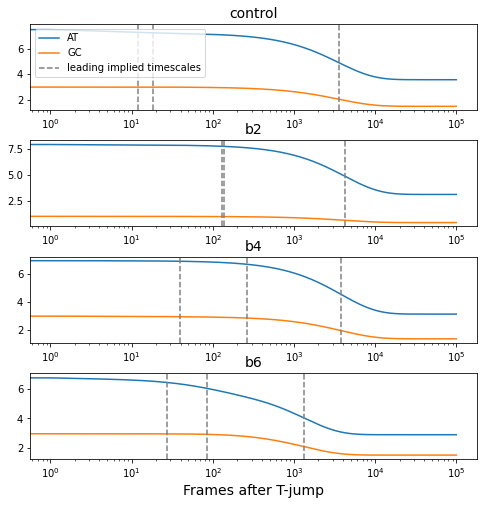

In [36]:
# relaxation experiments for AT and GC contributions

maxtime = 1e5
fsize = 14

fig, axes = plt.subplots(4, figsize=(8, 8))
for base, H, AT_scores, GC_scores, msm, dtraj_low, ax in \
        zip(base_list, H_list, AT_scores_list, GC_scores_list, msm_list, dtraj_low_list, axes):
    
    # determine starting distribution from low temp simulations
    p0 = []
    for i in range(msm.nstates):
        micro_sum = np.sum(np.concatenate(dtraj_low)==i)
        p0.append(micro_sum)
    p0 /= np.sum(p0)
    
    '''# determine using same temp hybridization groupings
    p0 = []
    for i in range(msm.nstates):
        if i in [H[0]]: p0.append(msm.stationary_distribution[i])
        else: p0.append(0)
    p0 /= np.sum(p0)
    
    # determine by highest combined score
    p0 = np.zeros(msm.nstates)
    combined_score = AT_scores+GC_scores
    most_hbr = np.argmax(combined_score)
    p0[most_hbr] = 1
    
    '''
    
    print(H, np.argmax(p0), p0[H])
    
    # run relaxation and plots
    times, AT_res = msm.relaxation(p0, AT_scores, maxtime=maxtime)
    times, GC_res = msm.relaxation(p0, GC_scores, maxtime=maxtime)

    ax.plot(times, AT_res, label=f'AT')
    ax.plot(times, GC_res, label=f'GC')
    ax.set_xscale('log')
    ax.set_title(base, fontsize=fsize)
    
    # plot leading timescales
    label = 'leading implied timescales'
    for ts in msm.timescales(3):
        ax.axvline(ts, linestyle='dashed', color='grey', label=label)
        label = ''

axes[0].legend()
axes[-1].set_xlabel('Frames after T-jump', fontsize=fsize)
plt.subplots_adjust(hspace=0.35)

4
control
leading timescales [3554.68765867   18.12243459   11.87863745    8.62321883]
AT amplitudes [3.633 0.004 0.    0.298]
GC amplitudes [1.511 0.    0.    0.   ]
b2
leading timescales [4221.8062781   137.23833225  129.43367434   12.69829207]
AT amplitudes [4.82  0.    0.    0.007]
GC amplitudes [0.599 0.002 0.    0.004]
b4
leading timescales [3816.16549037  263.79976493   39.62983206   28.46812023]
AT amplitudes [3.822e+00 1.000e-03 0.000e+00 1.000e-03]
GC amplitudes [1.594 0.    0.    0.023]
b6
leading timescales [1347.03499855   85.35110197   27.59630796   13.25366596]
AT amplitudes [3.016 0.759 0.    0.039]
GC amplitudes [1.511 0.    0.    0.   ]


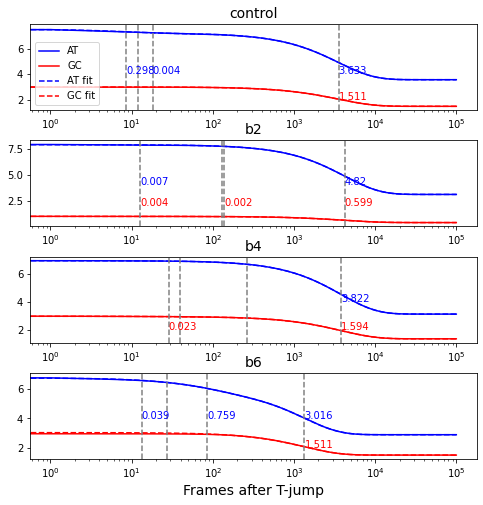

In [37]:
# try fitting a sum of exponentials to this to see how much each is contributing
from scipy.optimize import curve_fit

maxtime = 1e5
fsize = 14

lag = 1
nits = 4 #np.sum(msm.timescales()>lag) 
print(nits)

fig, axes = plt.subplots(4, figsize=(8, 8))
for base, H, AT_scores, GC_scores, msm, dtraj_low, ax in \
        zip(base_list, H_list, AT_scores_list, GC_scores_list, msm_list, dtraj_low_list, axes):
    
    def exp_sum_fit(x, *argv):
        #def exp_sum_fit(x, a, b1, b2, b3)
        '''fit sum of exponentials to determine amplitudes'''
    
        t_list =  msm.timescales(nits)
        exp_sum = argv[0]*np.ones(len(times))
        for t, b in zip(t_list, argv[1:]):
            exp_sum += b*np.exp(-x/t)
        
        #exp_sum = a + b1*np.exp(-x/t1) + b2*np.exp(-x/t2) + b3*np.exp(-x/t3)
        return exp_sum

    
    # determine starting distribution from low temp simulations
    p0 = []
    for i in range(msm.nstates):
        micro_sum = np.sum(np.concatenate(dtraj_low)==i)
        p0.append(micro_sum)
    p0 /= np.sum(p0)
    
    
    '''# determine using same temp hybridization groupings
    p0 = []
    for i in range(msm.nstates):
        if i in [H[0]]: p0.append(msm.stationary_distribution[i])
        else: p0.append(0)
    p0 /= np.sum(p0)
    
    # determine by highest combined score
    p0 = np.zeros(msm.nstates)
    combined_score = AT_scores+GC_scores
    most_hbr = np.argmax(combined_score)
    p0[most_hbr] = 1
    '''
    
    # run relaxation and plots
    times, AT_res = msm.relaxation(p0, AT_scores, maxtime=maxtime)
    times, GC_res = msm.relaxation(p0, GC_scores, maxtime=maxtime)
    
    # fit using summed exponentials
    p0 = [1]*(nits+1)
    AT_popt, _ = curve_fit(exp_sum_fit, times, AT_res, p0=p0, bounds=(0, 1000))
    AT_res_fit = exp_sum_fit(times, *AT_popt)
    GC_popt, _ = curve_fit(exp_sum_fit, times, GC_res, p0=p0, bounds=(0, 1000))
    GC_res_fit = exp_sum_fit(times, *GC_popt)

    ax.plot(times, AT_res, label=f'AT', color='blue')
    ax.plot(times, GC_res, label=f'GC', color='red')
    ax.set_xscale('log')
    ax.set_title(base, fontsize=fsize)
    
    ax.plot(times, AT_res_fit, linestyle='dashed', label=f'AT fit', color='blue')
    ax.plot(times, GC_res_fit, linestyle='dashed', label=f'GC fit', color='red')
    
    print(base)
    print('leading timescales', msm.timescales(nits))
    print('AT amplitudes', np.around(AT_popt[1:], 3))
    print('GC amplitudes', np.around(GC_popt[1:], 3))
    
    # plot leading timescales
    label = 'leading implied timescales'
    for ts, AT, GC in zip(msm.timescales(nits), AT_popt[1:], GC_popt[1:]):
        ax.axvline(ts, linestyle='dashed', color='grey')
        if AT > 0.001: ax.annotate(np.around(AT, 3), (ts, 4), color='blue')
        if GC > 0.001: ax.annotate(np.around(GC, 3), (ts, 2), color='red')

axes[0].legend()
axes[-1].set_xlabel('Frames after T-jump', fontsize=fsize)
plt.subplots_adjust(hspace=0.35)


#### Notes:
    - can we just decrease lag and evaluate performance (bettere detection of fraying?)
    - try reverse: hybridization

[31, 196] 177 [0. 0.]
[31, 196] 144 [0. 0.]
[31, 196] 177 [0. 0.]
[31, 196] 66 [0. 0.]


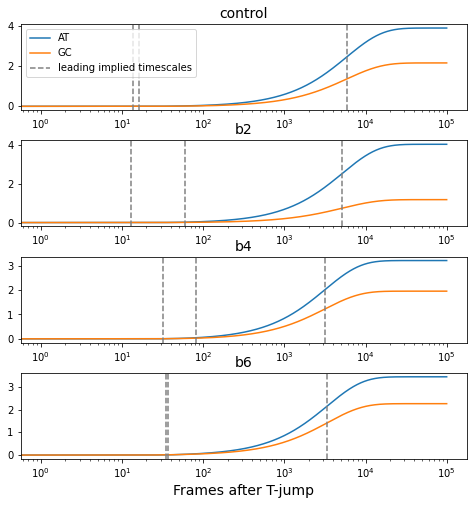

In [85]:
# evaluate dissocation using the D list

maxtime = 1e5
fsize = 14

fig, axes = plt.subplots(4, figsize=(8, 8))
for base, D, AT_scores, GC_scores, msm, dtraj_low, ax in \
        zip(base_list, D_list, AT_scores_list, GC_scores_list, msm_list, dtraj_low_list, axes):
    
    # determine using same temp hybridization groupings
    p0 = []
    for i in range(msm.nstates):
        if i in [D[0]]: p0.append(msm.stationary_distribution[i])
        else: p0.append(0)
    p0 /= np.sum(p0)
    
    # run relaxation and plots
    times, AT_res = msm.relaxation(p0, AT_scores, maxtime=maxtime)
    times, GC_res = msm.relaxation(p0, GC_scores, maxtime=maxtime)

    ax.plot(times, AT_res, label=f'AT')
    ax.plot(times, GC_res, label=f'GC')
    ax.set_xscale('log')
    ax.set_title(base, fontsize=fsize)
    
    # plot leading timescales
    label = 'leading implied timescales'
    for ts in msm.timescales(3):
        ax.axvline(ts, linestyle='dashed', color='grey', label=label)
        label = ''

axes[0].legend()
axes[-1].set_xlabel('Frames after T-jump', fontsize=fsize)
plt.subplots_adjust(hspace=0.35)

3
control
leading timescales [5868.29815752   16.05045151   13.48057908]
AT amplitudes [0. 0. 0.]
GC amplitudes [0. 0. 0.]
b2
leading timescales [5195.3151053    59.42034563   13.06754124]
AT amplitudes [0. 0. 0.]
GC amplitudes [0. 0. 0.]
b4
leading timescales [3162.32574133   81.98425325   32.20992714]
AT amplitudes [0. 0. 0.]
GC amplitudes [0. 0. 0.]
b6
leading timescales [3399.41808617   37.05796647   34.80379257]
AT amplitudes [0. 0. 0.]
GC amplitudes [0. 0. 0.]


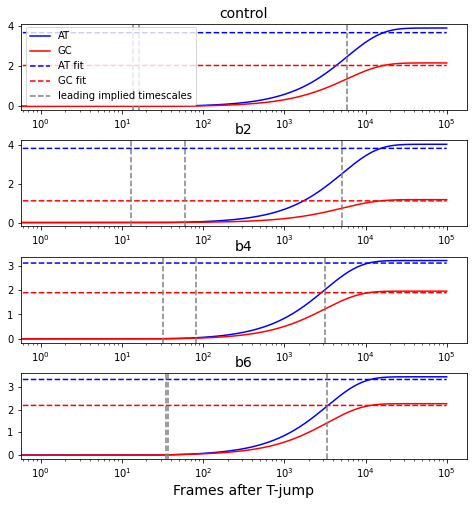

In [87]:
# try fitting a sum of exponentials to this to see how much each is contributing
from scipy.optimize import curve_fit

maxtime = 1e5
fsize = 14

lag = 1
nits = 3 #np.sum(msm.timescales()>lag) 
print(nits)

fig, axes = plt.subplots(4, figsize=(8, 8))
for base, D, AT_scores, GC_scores, msm, dtraj_low, ax in \
        zip(base_list, D_list, AT_scores_list, GC_scores_list, msm_list, dtraj_low_list, axes):
    
    def exp_sum_fit(x, *argv):
        #def exp_sum_fit(x, a, b1, b2, b3)
        '''fit sum of exponentials to determine amplitudes'''
    
        t_list =  msm.timescales(nits)
        exp_sum = argv[0]*np.ones(len(times))
        for t, b in zip(t_list, argv[1:]):
            exp_sum += b*np.exp(-x/t)
        
        #exp_sum = a + b1*np.exp(-x/t1) + b2*np.exp(-x/t2) + b3*np.exp(-x/t3)
        return exp_sum

    # determine using same temp hybridization groupings
    p0 = []
    for i in range(msm.nstates):
        if i in [D[0]]: p0.append(msm.stationary_distribution[i])
        else: p0.append(0)
    p0 /= np.sum(p0)
    
    # run relaxation and plots
    times, AT_res = msm.relaxation(p0, AT_scores, maxtime=maxtime)
    times, GC_res = msm.relaxation(p0, GC_scores, maxtime=maxtime)
    
    # fit using summed exponentials
    p0 = [1]*(nits+1)
    AT_popt, _ = curve_fit(exp_sum_fit, times, AT_res, p0=p0, bounds=(0, 1000))
    AT_res_fit = exp_sum_fit(times, *AT_popt)
    GC_popt, _ = curve_fit(exp_sum_fit, times, GC_res, p0=p0, bounds=(0, 1000))
    GC_res_fit = exp_sum_fit(times, *GC_popt)

    ax.plot(times, AT_res, label=f'AT', color='blue')
    ax.plot(times, GC_res, label=f'GC', color='red')
    ax.set_xscale('log')
    ax.set_title(base, fontsize=fsize)
    
    ax.plot(times, AT_res_fit, linestyle='dashed', label=f'AT fit', color='blue')
    ax.plot(times, GC_res_fit, linestyle='dashed', label=f'GC fit', color='red')
    
    print(base)
    print('leading timescales', msm.timescales(nits))
    print('AT amplitudes', np.around(AT_popt[1:], 3))
    print('GC amplitudes', np.around(GC_popt[1:], 3))
    
    # plot leading timescales
    label = 'leading implied timescales'
    for ts in msm.timescales(nits):
        ax.axvline(ts, linestyle='dashed', color='grey', label=label)
        label = ''

axes[0].legend()
axes[-1].set_xlabel('Frames after T-jump', fontsize=fsize)
plt.subplots_adjust(hspace=0.35)


W0719 15:56:05.056945 139690152826688 legend.py:1247] No handles with labels found to put in legend.


(12, 5)


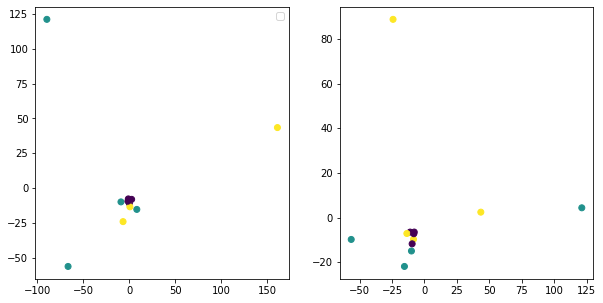

In [57]:
# perform kpca on correlation list and evecs
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA as kPCA

## try clustering msm evecs
n_evecs = 3
n_mode_list = []
base_list = []
evecs = []

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, msm in enumereate(msm_list):
    evecs += list(msm.eigenvectors_right(n_evecs+1).T[1:])
    n_mode_list += list(np.arange(n_evecs))
    
evecs = np.array(evecs)
n_mode_list = np.array(n_mode_list)

# PCA on correlation list
pca = kPCA(n_components=5, kernel='linear')
pca.fit(evecs)
y = pca.transform(evecs)


axes[0].scatter(y[:, 0], y[:, 1], c=n_mode_list)
axes[1].scatter(y[:, 1], y[:, 4], c=n_mode_list)
axes[0].legend()
print(np.shape(y))


(25, 100000, 5) (200,)


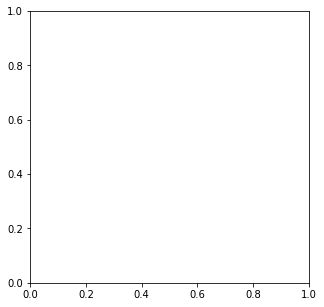

In [9]:
fig, axes = plt.subplots(figsize=(5, 5))
base_idx = 3

tic1 = np.concatenate(tica_indv_list[0][:, :, 0])
tic2 = np.concatenate(tica_indv_list[0][:, :, 1])
comm = committor_list[0]

print(np.shape(tica_indv_list[0]), np.shape(committor_list[0]))

